In [6]:
# %load LuiseUtil.py
import os
import shutil
import math
from ete3 import Tree
from Bio import Phylo
import matplotlib
import matplotlib.pyplot as plt

tree_dir = '../data/trees/'
alignment_dir = '../data/language_alignments/'
sitelh_dir = '../data/siteLH/'
drawings_dir = '../output/drawings/'
weight_calibration_dir = '../data/weight_calibration/'
site_congruence_dir = '../data/site_congruence/'
lh_dir = '../data/lh/'

#tree_space_name = 'space.trees'
geo_tree_name = "geo_basic.tree"
cognate_tree_name = "cognate_ie_compatible.tree"
cognate_ml_tree_name = "cognate_ml.tree"

morpho_alignment_name = "morpho.phy"



def read_trees_from_ete(tree_set_names):
    trees = []
    for tree_set in tree_set_names:
        l_file = open(tree_dir + tree_set, 'r')
        lines = l_file.readlines()
        for line in lines:
            trees.append(Tree(line))
    print(str(len(trees)) + " trees read")
    return trees

#def read_tree_space_ete():
#    return read_trees_from_ete([tree_space_name])


def eliminate_topological_duplicates_ete(tree_set_name):
    unique_list = []
    tree_set_ete = read_trees_from_ete([tree_set_name])
    i = 0
    for t1 in tree_set_ete:
        print("tree " + str(i))
        unique = True
        for t2 in unique_list:
            rf = rf_distance_ete(t1, t2)
            if rf == 0:
                unique = False
                break
        if unique:
            unique_list.append(t1)
            print(str(len(unique_list)) + " unique trees")
        i = i + 1
    file_name = tree_dir + rm_end(tree_set_name) + '_unique.trees'
    with open(file_name, 'w+') as tree_file:
        for tree in unique_list:
            tree_file.write(tree.write()+"\n")



#def create_tree_space_from(tree_set_names):
#    tree_space_ete = read_trees_from_ete(tree_set_names)
#    file_name = tree_dir + tree_space_name
#    with open(file_name, 'w+') as tree_file:
#        for tree in tree_space_ete:
#            tree_file.write(tree.write()+"\n")
#    print(str(len(tree_space_ete)) + " trees written to " + file_name)

def read_geo_tree_ete():
    return Tree(tree_dir + geo_tree_name)

def read_cognate_tree_ete():
    return Tree(tree_dir + cognate_tree_name)

def rf_distance_ete(t1, t2):
    rf, max_rf, common_leaves, parts_t1, parts_t2,discard_t1, discart_t2 = t1.robinson_foulds(t2, unrooted_trees = True)
    if max_rf == 0:
        return 0
    return rf/max_rf

def rf_distances_ete(ref_tree, tree_set):
    distances = []
    for tree in tree_set:
        distances.append(rf_distance_ete(ref_tree, tree))
    return distances


def calculate_rf_distances_raxml(ref_tree_name, tree_set_names):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    dir_string = tree_dir + ref_tree_name
    for tree_set in tree_set_names:
        dir_string = dir_string + tree_dir + tree_set
    os.system("cat " + dir_string + " > temp/all.trees")
    os.system("./../raxml-ng/build/bin/raxml-ng --rfdist --tree temp/all.trees --prefix temp/foo > temp/bar.txt")
    l_file = open('temp/foo.raxml.rfDistances', 'r')
    lines = l_file.readlines()
    i = 0
    line = lines[i].split("\t")
    distances = []
    while(line[0] == '0'):
        distances.append(float(line[3]))
        i+=1
        line = lines[i].split("\t")
    shutil.rmtree("temp/", ignore_errors=True)
    return distances


def evaluate_lh_raxml(tree_name, alignment_name, optimize = True):
    optimize_string = ""
    if not optimize:
        optimize_string = " --opt-branches off "
    os.system('./../raxml-ng/build/bin/raxml-ng --evaluate --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --model BIN+G --tree '  + tree_dir + tree_name +  ' --prefix foo --nofiles' +
              optimize_string + '> out.txt')
    l_file = open('out.txt', 'r')
    lines = l_file.readlines()
    lh = 0
    for line in lines:
        if(line.startswith('Final LogLikelihood:')):
            lh = float(line.split(" ")[2].strip())
    os.remove("out.txt")
    return lh




def calculate_site_lh_raxml_ete(tree_ete, alignment_name, optimize= True):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    tree_ete.write(outfile="temp/foo.tree")
    optimize_string = ""
    if not optimize:
        optimize_string = " --opt-branches off "
    os.system('./../raxml-ng/build/bin/raxml-ng --sitelh --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --model BIN+G --tree temp/foo.tree --prefix temp/foo ' +
              optimize_string + '> temp/bar.txt')
    l_file = open('temp/foo.raxml.log', 'r')
    lines = l_file.readlines()
    lh = 0
    for line in lines:
        if(line.startswith('Final LogLikelihood:')):
            lh = float(line.split(" ")[2].strip())
    with open('temp/foo.raxml.siteLH' , 'r') as file:
        data = (file.read().replace('\n', '')).split(" ")
    siteLH = [float(data[i]) for i in range(5, len(data))]
    shutil.rmtree("temp/", ignore_errors=True)
    return [lh, siteLH]




def print_tree_with_phylo(tree_name, save = False):
    tree = Phylo.read(tree_dir + tree_name, "newick")
    tree.ladderize()
    fig = plt.figure(figsize=(10, 10), dpi=100)
    axes = fig.add_subplot(1, 1, 1)
    axes.set_title(tree_name)
    Phylo.draw(tree, axes=axes, do_show=False)
    if save:
        plt.savefig(drawings_dir + tree_name + '.png', dpi=fig.dpi)


def fix_beast_output(tree_set_name):
    beast_file = open(tree_dir + tree_set_name, 'r')
    lines = beast_file.readlines()
    i = 0
    while not lines[i].startswith("\tTranslate"):
        i = i+1
    translate = []
    while not lines[i].startswith(";"):
        if lines[i].endswith(",\n"):
            translate.append(lines[i].split(" ")[-1][:-2])
        else:
            translate.append(lines[i].split(" ")[-1][:-1])
        i=i+1
    i = i+1
    with open(tree_dir + rm_end(tree_set_name) + "_fixed.trees" , 'w+') as fixed_file:
        for j in range(i, len(lines)-1):
            tree = Tree(lines[j].split(" ")[-1])
            for leaf in tree.iter_leaves():
                leaf.name = translate[int(leaf.name)]
            fixed_file.write(tree.write() + "\n")

def rm_end(file_name):
    return '.'.join(file_name.split('.') [:-1])

def lh_file_name(tree_set_name, alignment_name, optimize):
    optimize_string = "_opt-branches="
    if optimize:
        optimize_string = optimize_string + "on"
    else:
        optimize_string = optimize_string + "off"
    return lh_dir + rm_end(alignment_name) + '_' + rm_end(tree_set_name)  + optimize_string + '.lh'


def site_lh_file_name(tree_name, alignment_name, optimize):
    optimize_string = "_opt-branches="
    if optimize:
        optimize_string = optimize_string + "on"
    else:
        optimize_string = optimize_string + "off"
    return sitelh_dir + rm_end(alignment_name) + '_' + rm_end(tree_name)  + optimize_string + '.raxml.siteLH'

def weight_calibration_file_name(tree_name, alignment_name):
    return weight_calibration_dir + rm_end(alignment_name) + '_' + rm_end(tree_name)  + '.raxml.weightCalibration'

def site_congruence_file_name(tree_name, alignment_name):
    return site_congruence_dir + rm_end(alignment_name) + '_' + rm_end(tree_name)  + '.raxml.siteCongruence'

def optimized_tree_file_name(tree_name, alignment_name):
    return tree_dir + rm_end(tree_name) + '_optimized_' + rm_end(alignment_name)  + '.tree'


def read_lhs(tree_set_name, alignment_name, optimize):
    lhs = []
    site_lhs = []
    with open(lh_file_name(tree_set_name, alignment_name, optimize) , 'r') as file:
        lines = file.read().split("\n")
    for line in lines[:-1]:
        line_data = line.split("\t")
        lhs.append(float(line_data[0]))
        site_lhs.append([float(el) for el in line_data[1].split(" ")[:-1]])
    return (lhs, site_lhs)

def read_site_lh(tree_name, alignment_name, optimize):
    with open(site_lh_file_name(tree_name, alignment_name, optimize) , 'r') as file:
        data = (file.read().replace('\n', '')).split(" ")
    return [float(data[i]) for i in range(5, len(data))]

def read_weight_calibration(tree_name, alignment_name):
    with open(weight_calibration_file_name(tree_name, alignment_name) , 'r') as file:
        data = file.read().split(" ")
    return [int(data[i]) for i in range(len(data) - 1)]

def read_site_congruence(tree_name, alignment_name):
    with open(site_congruence_file_name(tree_name, alignment_name) , 'r') as file:
        data = file.read().split("\n")
    return [float(data[i].split(" ")[1]) for i in range(len(data) - 1)]

def read_optimized_tree(tree_name, alignment_name):
    return Tree(optimized_tree_file_name(tree_name, alignment_name))

def calculate_lhs_raxml(tree_set_name, alignment_name, optimize = False):
    tree_set = read_trees_from_ete([tree_set_name])
    results = [calculate_site_lh_raxml_ete(tree, alignment_name, optimize) for tree in tree_set]
    with open(lh_file_name(tree_set_name, alignment_name, optimize), 'w+') as out_file:
        for result in results:
            out_file.write(str(result[0]))
            out_file.write("\t")
            for site_lh in result[1]:
                out_file.write(str(site_lh))
                out_file.write(" ")
            out_file.write("\n")

def calculate_site_lh_raxml(tree_name, alignment_name, optimize= True):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    optimize_string = ""
    if not optimize:
        optimize_string = " --opt-branches off "
    os.system('./../raxml-ng/build/bin/raxml-ng --sitelh --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --model BIN+G --tree '  + tree_dir + tree_name +  ' --prefix temp/foo ' +
              optimize_string + '> temp/bar.txt')
    l_file = open('temp/foo.raxml.log', 'r')
    lines = l_file.readlines()
    lh = 0
    for line in lines:
        if(line.startswith('Final LogLikelihood:')):
            lh = float(line.split(" ")[2].strip())
    os.system("cat temp/foo.raxml.siteLH > " + site_lh_file_name(tree_name, alignment_name, optimize))
    with open('temp/foo.raxml.siteLH' , 'r') as file:
        data = (file.read().replace('\n', '')).split(" ")
    siteLH = [float(data[i]) for i in range(5, len(data))]
    shutil.rmtree("temp/", ignore_errors=True)

def calculate_weight_calibration_raxml(tree_name, alignment_name):
    os.system('./../standard-RAxML-master/raxmlHPC -f u -p 12345 -t ' + tree_dir + tree_name +
              ' -m BINGAMMA -s ' + alignment_dir + alignment_name +
              ' -n calibration > bar.txt')
    os.system('cat RAxML_weights.calibration > '
              + weight_calibration_file_name(tree_name, alignment_name))
    os.remove('bar.txt')
    os.remove('RAxML_weights.calibration')
    os.remove('RAxML_info.calibration')

def calculate_site_congruence_raxml(tree_name, alignment_name):
    os.system('./../standard-RAxML-master/raxmlHPC -f S -t ' + tree_dir + tree_name +
              ' -m BINGAMMA -s ' + alignment_dir + alignment_name +
              ' -n congruence > bar.txt')
    os.system('cat RAxML_SiteSpecificPlacementBias.congruence > '
              + site_congruence_file_name(tree_name, alignment_name))
    os.remove('bar.txt')
    os.remove('RAxML_SiteSpecificPlacementBias.congruence')
    os.remove('RAxML_info.congruence')

def calculate_optimized_tree_raxml(tree_name, alignment_name):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    os.system('./../raxml-ng/build/bin/raxml-ng --evaluate --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --model BIN+G --tree '  + tree_dir + tree_name +  ' --prefix temp/foo ' + '> out.txt')
    os.system('cat temp/foo.raxml.bestTree > ' + tree_dir + rm_end(tree_name) + "_optimized_" + rm_end(alignment_name) + '.tree')
    shutil.rmtree("temp/", ignore_errors=True)


def get_site_lh(tree_name, alignment_name, optimize):
    if not os.path.isfile(site_lh_file_name(tree_name, alignment_name, optimize)):
        calculate_site_lh_raxml(tree_name, alignment_name, optimize)
    return read_site_lh(tree_name, alignment_name, optimize)


def get_weight_calibration(tree_name, alignment_name):
    if not os.path.isfile(weight_calibration_file_name(tree_name, alignment_name)):
        calculate_weight_calibration_raxml(tree_name, alignment_name)
    return read_weight_calibration(tree_name, alignment_name)

def get_site_congruence(tree_name, alignment_name):
    if not os.path.isfile(site_congruence_file_name(tree_name, alignment_name)):
        calculate_site_congruence_raxml(tree_name, alignment_name)
    return read_site_congruence(tree_name, alignment_name)

def get_optimized_tree(tree_name, alignment_name):
    if not os.path.isfile(optimized_tree_file_name(tree_name, alignment_name)):
        calculate_optimized_tree_raxml(tree_name, alignment_name)
    return read_optimized_tree(tree_name, alignment_name)

def get_double_optimized_tree(tree_name, alignment_name):
    if not os.path.isfile(optimized_tree_file_name(tree_name, alignment_name)):
        calculate_optimized_tree_raxml(tree_name, alignment_name)
    optimized_tree_name = optimized_tree_file_name(tree_name, alignment_name).split('/')[-1]
    if not os.path.isfile(optimized_tree_file_name(optimized_tree_name, alignment_name)):
        calculate_optimized_tree_raxml(optimized_tree_name, alignment_name)
    return read_optimized_tree(optimized_tree_name, alignment_name)


def get_optimized_tree(tree_name, alignment_name):
    if not os.path.isfile(optimized_tree_file_name(tree_name, alignment_name)):
        calculate_optimized_tree_raxml(tree_name, alignment_name)
    return read_optimized_tree(tree_name, alignment_name)


def get_lhs(tree_set_name, alignment_name, optimize):
    if not os.path.isfile(lh_file_name(tree_set_name, alignment_name, optimize)):
        calculate_lhs_raxml(tree_set_name, alignment_name, optimize)
    return read_lhs(tree_set_name, alignment_name, optimize)


def average_branch_length(tree_set):
    avg = 0
    cnt = 0
    for tree in tree_set:
        for node in tree.traverse():
            avg = avg + node.dist
            cnt = cnt + 1
    avg = avg / cnt
    return avg



def interval_branch_length(tree_set):
    lower = 1
    upper = 0
    for tree in tree_set:
        for node in tree.traverse():
            lower = min(lower, node.dist)
            upper = max(upper, node.dist)
    return (lower, upper)



def variance_branch_length(tree_set):
    avg = average_branch_length(tree_set)
    var = 0
    cnt = 0
    for tree in tree_set:
        for node in tree.traverse():
            diff = node.dist - avg
            var = var + (diff * diff)
            cnt = cnt + 1
    return var / cnt







In [7]:
def mixture_model_lh(siteLH, g_siteLH, d):
    d1 = (d + 1) / 2
    lh_sum = 0
    for i in range(len(siteLH)):
        L = math.pow(math.e, siteLH[i])
        L_G = math.pow(math.e, g_siteLH[i])
        w = g_siteLH[i] / (g_siteLH[i] + siteLH[i]) #would it make sense to use llh here?
        w1 = 1
        if(L_G > L):
            w1 = (w + d1) / 2
        else:
            w1 = (w + (1 - d1)) / 2
        L1 = math.log((1 - w1) * L + w1 * L_G)
        lh_sum = lh_sum  + L1
    return lh_sum
        

In [8]:
def calculate_mmlhs(siteLHs, g_siteLH, rf_distances):
    return [mixture_model_lh(siteLHs[i], g_siteLH, rf_distances[i]) for i in range(len(siteLHs))]

In [9]:
def get_ranks(lhs):
    target = sorted(lhs, reverse = True)
    return [target.index(lh) for lh in lhs]

17 trees read


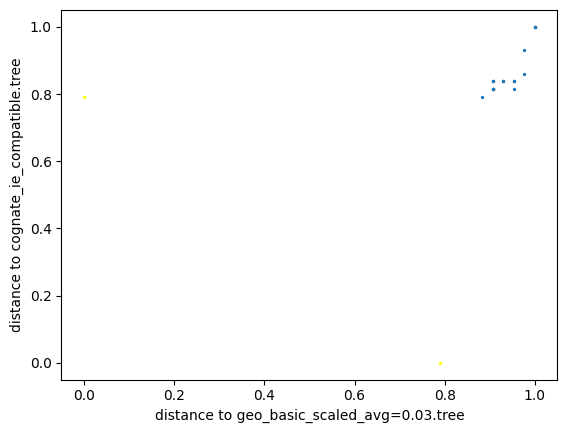

In [11]:
geo_tree_name = "geo_basic_scaled_avg=0.03.tree"
#geo_tree = read_geo_tree_ete()
geo_tree = Tree(tree_dir + 'geo_science.tree')
cognate_tree = read_cognate_tree_ete()
tree_set = read_trees_from_ete(["pars_100_rand_100_unique.trees"])
geo_rf_distances = rf_distances_ete(geo_tree, tree_set)
cognate_rf_distances = rf_distances_ete(cognate_tree, tree_set)
cg_distance = rf_distance_ete(geo_tree, cognate_tree)
plt.scatter(geo_rf_distances, cognate_rf_distances, s=2)
plt.scatter([0, cg_distance], [cg_distance, 0], c ="yellow", s=2)
plt.xlabel("distance to " + geo_tree_name)
plt.ylabel("distance to " + cognate_tree_name)
plt.show()

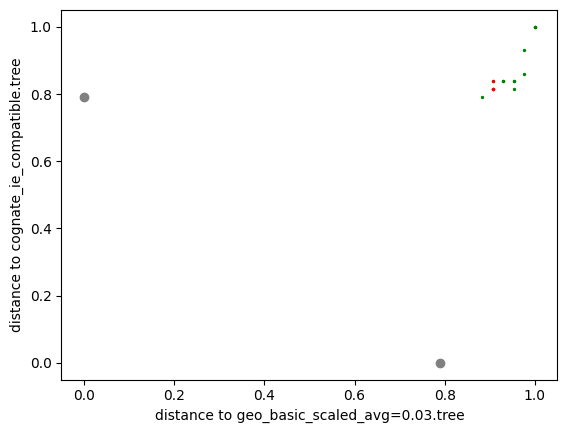

In [12]:
g_siteLH = get_site_lh('geo_science.tree', morpho_alignment_name, False)
(lhs, siteLHs) = get_lhs("pars_100_rand_100_unique.trees", morpho_alignment_name, False)
mmlhs = calculate_mmlhs(siteLHs, g_siteLH, geo_rf_distances)
lh_ranks = get_ranks(lhs)
mmlh_ranks = get_ranks(mmlhs)

#for i in range(len(lhs)):
#    print("LH: " + str(lhs[i]) + " Rank: " + str(lh_ranks[i]) + " MMLH: " + str(mmlhs[i]) + " Rank: "+ str(mmlh_ranks[i]))
    
good = []
bad = []
for i in range(len(lhs)):
    if(mmlh_ranks[i] <= lh_ranks[i]):
        good.append(i)
    else:
        bad.append(i)
plt.scatter([0, cg_distance], [cg_distance, 0], c ="grey")
plt.scatter([geo_rf_distances[i] for i in good], [cognate_rf_distances[i] for i in good], c = 'green', s=2)
plt.scatter([geo_rf_distances[i] for i in bad], [cognate_rf_distances[i] for i in bad], c = 'red', s=2)
plt.xlabel("distance to " + geo_tree_name)
plt.ylabel("distance to " + cognate_tree_name)
plt.show()